In [1]:
import numpy as np # Numpy is a popular numeric computation package
import pandas as pd # Pandas is a friendly data wrangling package/library
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Setting a specific random seed, to get reproducibility across students.
# @Students, you can remove or change to your own seed to try with your own training subsets.
np.random.seed(100) 

In [2]:
class GP:
    def __init__(self,cov_function_name, x_train, y_train, hyper_params, sigma_n):
        self.verbose = False
        self.cov_function_name = cov_function_name
        self.x_train = x_train
        self.y_train = y_train
        self.hyper_params = hyper_params #params[0] is signal variance, params[1] is lengthscale
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def predict(self,x_star):
        k_star = self.cov_func(self.x_train,x_star)
        f_mean = np.transpose(k_star) @ self.K_inv @ self.y_train
        f_std = self.cov_func(x_star, x_star) - np.transpose(k_star) @ self.K_inv @ k_star
        f_std = np.sqrt(np.diag(f_std))[:,np.newaxis]
        return [f_mean,f_std]
    
    def set_training_data(self,x,y):
        self.x_train = x
        self.y_train = y
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))

    def cov_func(self,x_1,x_2):
        if self.cov_function_name == "Squared Exponential":
            x_1_sq = np.sum(np.square(x_1),1)
            x_2_sq = np.sum(np.square(x_2),1)
            d = -2.*np.dot(x_1, x_2.T) + (x_1_sq[:,None] + x_2_sq[None,:])
            K = self.hyper_params[0]**2 * np.exp(-0.5 * d/self.hyper_params[1]**2)
        return K
    
    def set_hyper_params(self, hyper_params, sigma_n):
        self.hyper_params = hyper_params
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def log_marginal_likelihood(self):
        lml1 = -.5*(np.transpose(self.y_train) @ self.K_inv @ self.y_train)
        #! Very important - Last tutorial the log marginal likelihood term was missing and np.log for the determinant.
        #! Results in an over estimation of the noise
        lml2 = -.5*np.log(np.linalg.det(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2)))
        lml3 = -.5*self.x_train.shape[0]*np.log(2*np.pi)
        return lml1+lml2+lml3
    
    def fit(self):
        print("GP Optimising Hyper-parameters")
        from scipy.optimize import minimize

        def eval_params(params, gp):
            params = np.exp(params)
            gp.set_hyper_params(params[:-1],params[len(params)-1])
            nlml = -gp.log_marginal_likelihood()
            if gp.verbose:
                print(str(params)+str(nlml))
            return nlml

        x0 = np.array([np.log(2), np.log(0.8), np.log(0.3)])
        res = minimize(eval_params, x0, method='nelder-mead', args=(self),
                       options={'xatol': 1e-10, 'disp': False})
        if res.success:
            print("Optimisation results: ")
            optimal_params = np.exp(res.x)
            print(optimal_params)
            print("LML")
            print(self.log_marginal_likelihood())
            self.set_hyper_params([optimal_params[0],optimal_params[1]],optimal_params[2])
        else:
            print("Error when fitting GP.")

### Plot of the objective function

The following cell defines the objective function to be optimised.

\begin{equation}
f(x) = 6x^2\sin{(5\pi x)}+\epsilon \,\,,
\end{equation}
where $\epsilon \sim \mathcal{N}(0,0.2^2)$ and $x\in [0,1]$

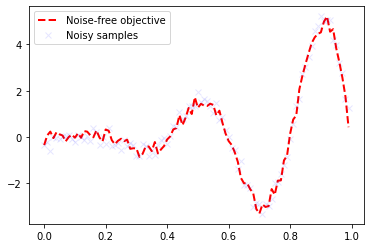

In [3]:
# Definition of the objective function
def f(x, noise=0):
    return 6*(x**2)*np.sin(5*np.pi*x)+ np.random.randn(*x.shape)*0.2

# Dense grid of points within bounds for plotting
bounds = np.array([[0, 1.0]])
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

noise = 0.1 #Measurement noise for f

# Plot optimization objective with noise level 
plt.plot(X, f(X,noise=0), 'r--', lw=2, label='Noise-free objective')
plt.plot(X, f(X,noise=noise), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.legend();

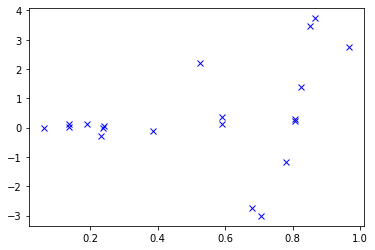

In [4]:
n_samples = 20
x_train = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=n_samples)[:,np.newaxis]
y_train = f(x_train,noise)

plt.plot(x_train, y_train, 'bx', label='Noisy samples')

GP Optimising Hyper-parameters
Optimisation results: 
[2.08452975 0.08957224 0.19067521]
LML
[[-20.36545736]]


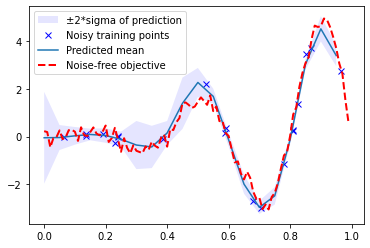

In [5]:
signal_variance = 12.05
lengthscale = 1.45
sigma_n = 14.43

x_star = np.arange(bounds[:, 0], bounds[:, 1], 0.05).reshape(-1, 1)

gp = GP("Squared Exponential", x_train, y_train, [signal_variance,lengthscale], sigma_n)
gp.fit()

[f_mean,f_std] = gp.predict(x_star)

plt.fill_between(x_star.ravel(), (f_mean-1.96*f_std).ravel(), (f_mean+1.96*f_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
plt.plot(x_train, y_train, 'bx', label='Noisy training points')
plt.plot(x_star, f_mean, label="Predicted mean")
plt.plot(X, f(X,noise=0), 'r--', lw=2, label='Noise-free objective')
plt.legend()

In [6]:
def EI(X, X_sample, Y_sample, gpr, xi=0.05):
    
    mu, std = gp.predict(X)
    y_plus = np.max(Y_sample)
    
    Z = (mu - y_plus - xi)/std
    
    ei = std*(Z*norm.cdf(Z) + norm.pdf(Z))
    
    return ei

In [7]:
def ucb(X, X_sample, Y_sample, gp, kappa=1):
    mu, std = gp.predict(X)
    ucb_val = mu + kappa*std

    return ucb_val

In [8]:
def PI(X, X_sample, Y_sample, gpr, xi=0.05):
    
    mu, std = gp.predict(X)
    y_plus = np.max(Y_sample)
    
    Z = (mu - y_plus - xi)/std
    
    pi = norm.cdf(Z) 
    
    return pi

In [9]:
def arg_max_aq_func(ac_func, X_sample, Y_sample, gp, bounds, n_restarts=25):
    # Domain to evaluate the acquisition function
    x_sample_aq = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
    # Values of the acquisition function over the domain
    aq_values = ac_func(x_sample_aq, X_sample, Y_sample, gp)
    # Argmax of the acquisition funcion values
    return x_sample_aq[np.argmax(aq_values)]

In [10]:
def plot_acquisition_function(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r.', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    

def plot_gp_regression(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X)
    plt.plot(X, Y, 'r--', lw=1, label='Noise-free objective')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    plt.plot(X_domain, mu, 'b', lw=1, label='Surrogate function')
    plt.fill_between(X_domain.ravel(), 
                     mu.ravel() + 1.96 * std.ravel(), 
                     mu.ravel() - 1.96 * std.ravel(), 
                     alpha=0.1) 
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

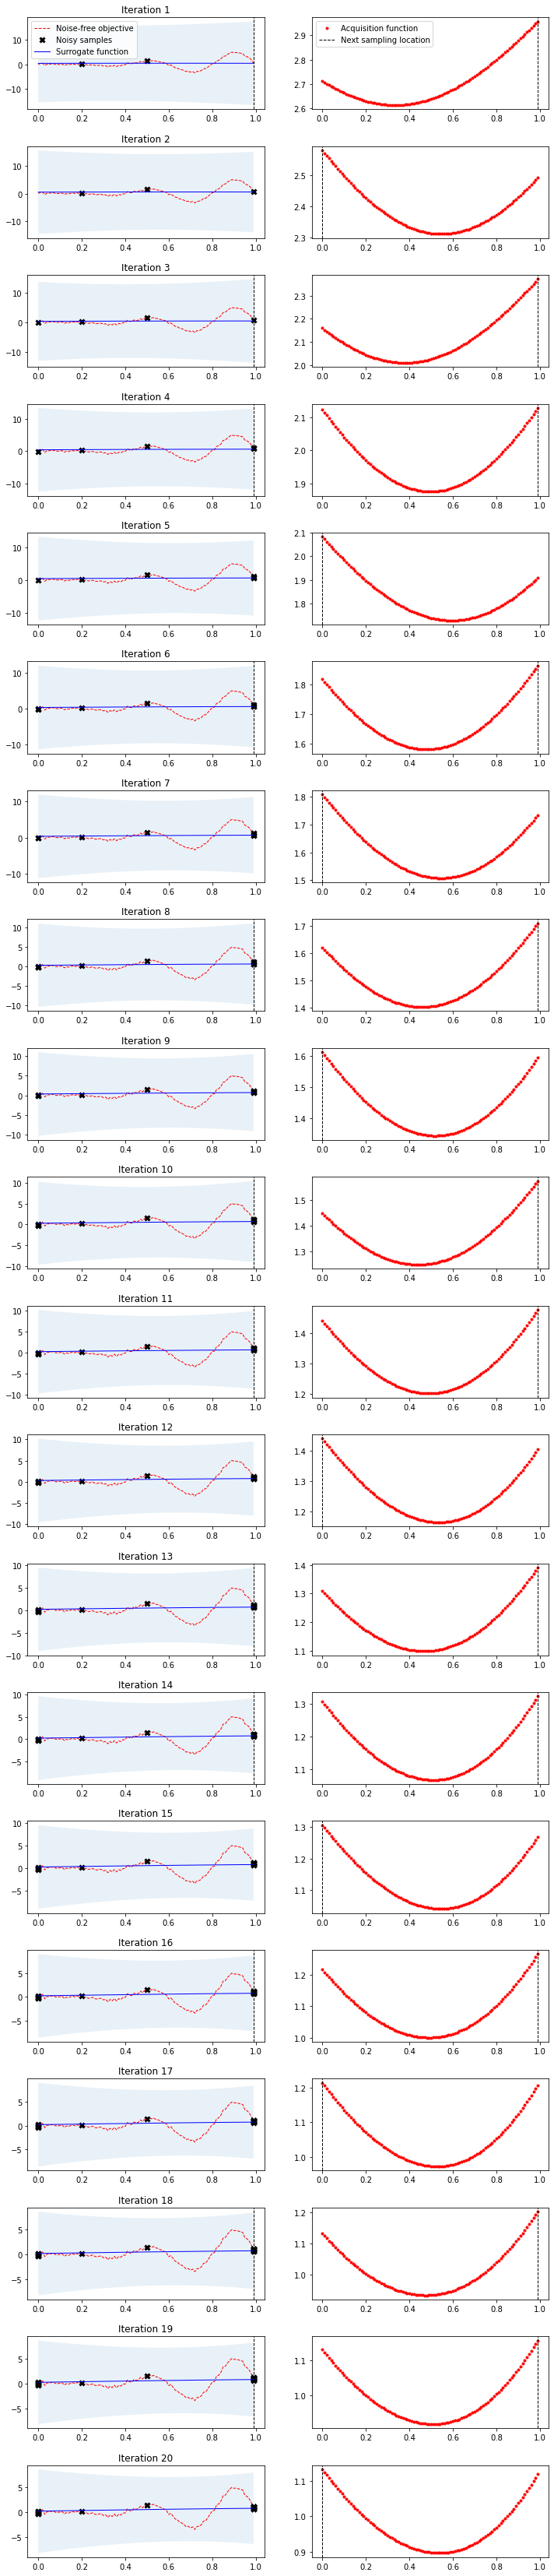

In [11]:
#perfect values of function (just for plotting)
X_domain = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
y_perfect = f(X_domain,noise=0)

X_init = np.array([[0.2], [0.5]])
Y_init = f(X_init)

# acquisition_function
#aq_func = ucb
aq_func = EI
#aq_func = PI

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 20

#Cumulative regret
Cum_R_EI = 0

#Regret 
R_EI = []

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

gp = GP("Squared Exponential",x_train, y_train, [signal_variance,lengthscale], sigma_n)


for i in range(n_iter):
    
    # 1. Update GP
    gp.set_training_data(X_sample, Y_sample)
    
    # 2. Calculate X_next
    X_next = arg_max_aq_func(aq_func, X_sample, Y_sample, gp, bounds)
    
    # 3. Acquire next observation
    Y_next = f(X_next, noise)
    
    # Plotting
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_gp_regression(gp, X_domain, y_perfect, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition_function(X_domain, aq_func(X_domain, X_sample, Y_sample, gp), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    
    R_EI.append(4.908 - f(X_next))
    Cum_R_EI += R_EI[i]  

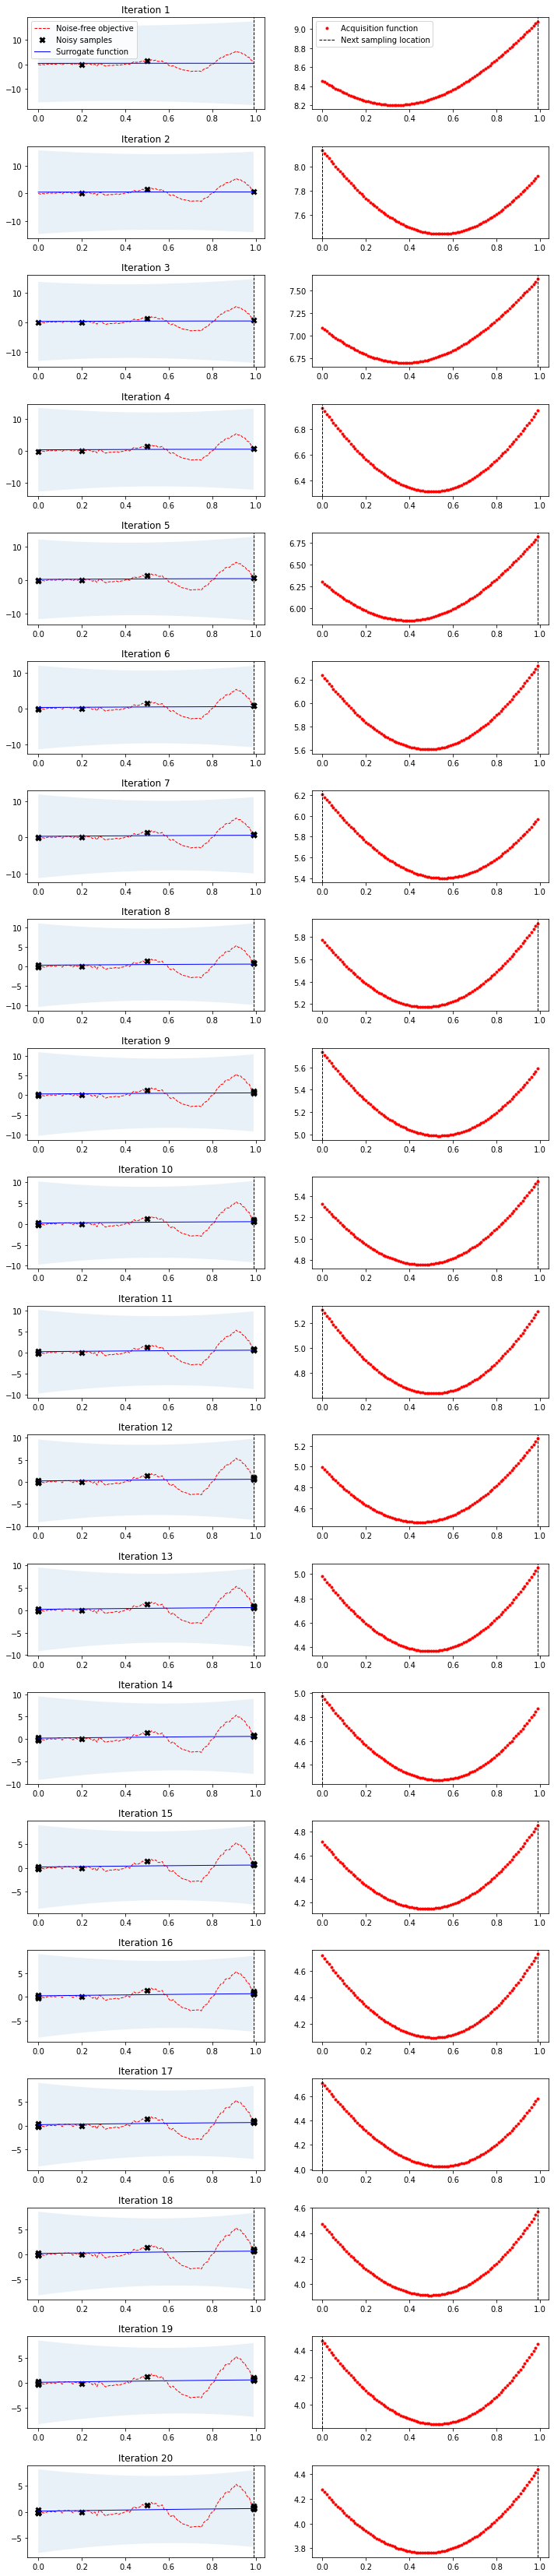

In [12]:
#perfect values of function (just for plotting)
X_domain = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
y_perfect = f(X_domain,noise=0)

X_init =  np.array([[0.2], [0.5]])
Y_init = f(X_init)

# acquisition_function
aq_func = ucb
#aq_func = EI
#aq_func = PI

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 20

#Cumulative regret
Cum_R_UCB = 0

#Regret 
R_UCB = []

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

gp = GP("Squared Exponential",x_train, y_train, [signal_variance,lengthscale], sigma_n)


for i in range(n_iter):
    
    # 1. Update GP
    gp.set_training_data(X_sample, Y_sample)
    
    # 2. Calculate X_next
    X_next = arg_max_aq_func(aq_func, X_sample, Y_sample, gp, bounds)
    
    # 3. Acquire next observation
    Y_next = f(X_next, noise)
    
    # Plotting
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_gp_regression(gp, X_domain, y_perfect, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition_function(X_domain, aq_func(X_domain, X_sample, Y_sample, gp), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    
    R_UCB.append(4.908 - f(X_next))
    Cum_R_UCB += R_UCB[i]    

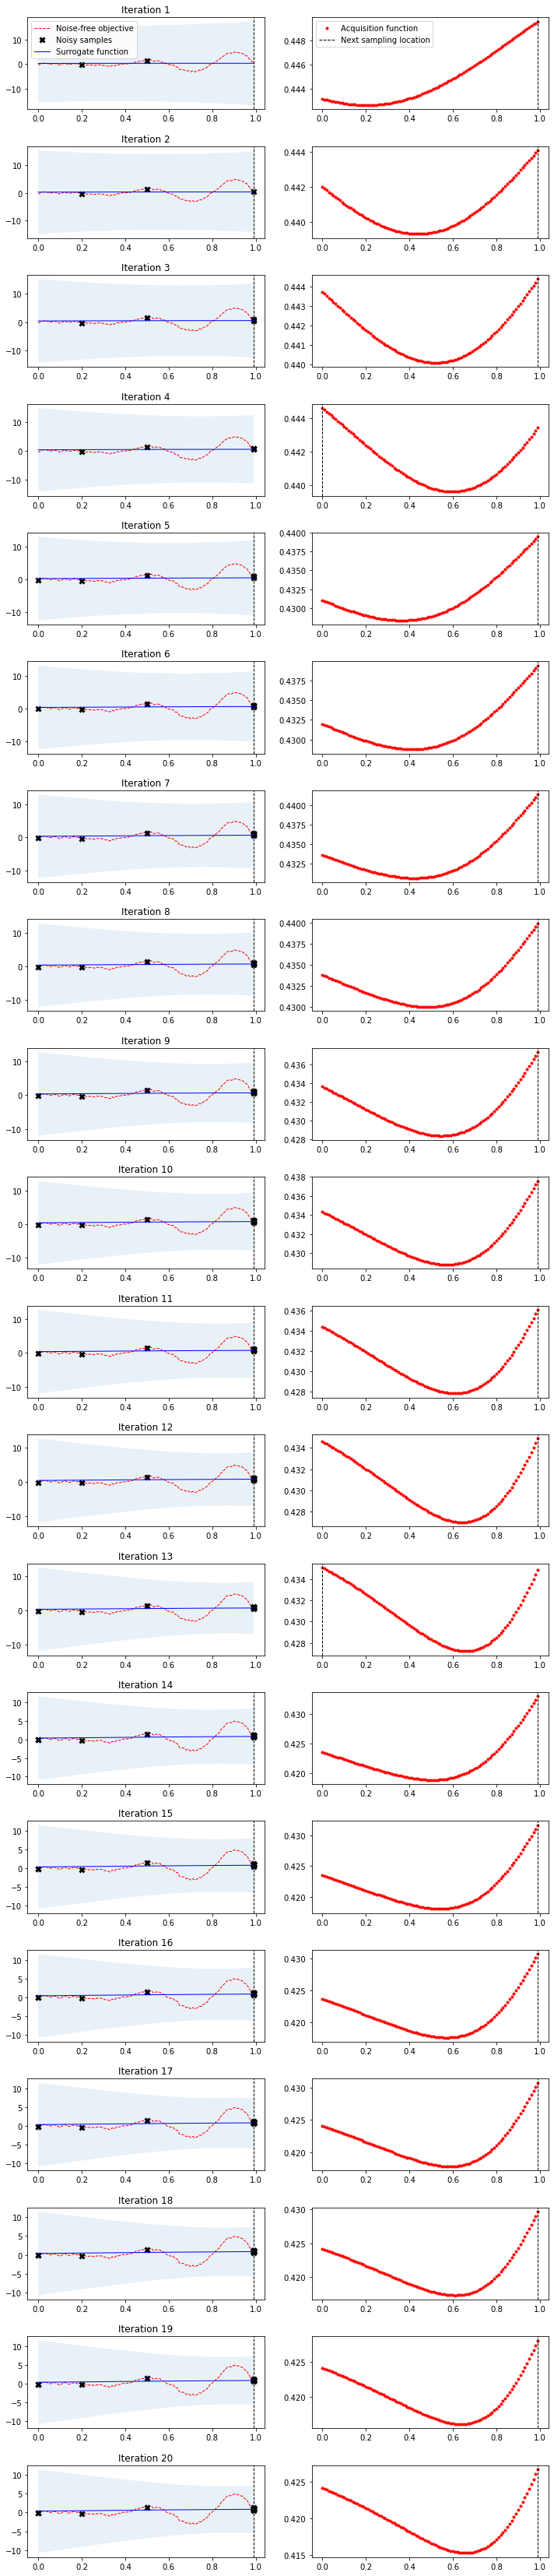

In [13]:
#perfect values of function (just for plotting)
X_domain = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
y_perfect = f(X_domain,noise=0)

X_init = np.array([[0.2], [0.5]])
Y_init = f(X_init)

# acquisition_function
#aq_func = ucb
#aq_func = EI
aq_func = PI

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 20

#Cumulative regret
Cum_R_PI = 0

#Regret 
R_PI = []

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

gp = GP("Squared Exponential",x_train, y_train, [signal_variance,lengthscale], sigma_n)


for i in range(n_iter):

    # 1. Update GP
    gp.set_training_data(X_sample, Y_sample)
    
    # 2. Calculate X_next
    X_next = arg_max_aq_func(aq_func, X_sample, Y_sample, gp, bounds)
    
    # 3. Acquire next observation
    Y_next = f(X_next, noise)
    
    # Plotting
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_gp_regression(gp, X_domain, y_perfect, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition_function(X_domain, aq_func(X_domain, X_sample, Y_sample, gp), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    
    R_PI.append(4.908 - f(X_next))
    Cum_R_PI += R_PI[i]
    
    

The global maximum of f in the domain $[-1,1]$ is $f(x^*) = 4.908$ with $x^*= 0.909$, so for each acquisiton function, we calculated $R(f,i) = f(x^*) - f(x^{BO_i}) = 4.908 - f(x^{BO_i}) $

Now we will plot the three regrets over time to compare, and also look at the final and cumulative regrets.

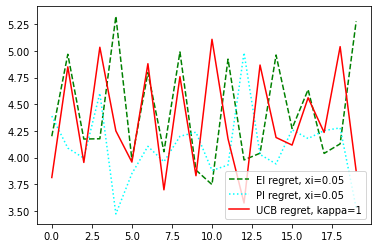

Cumulative EI regret is [88.55984818]
Cumulative PI regret is [82.17505865]
Cumulative UCB regret is [86.77728664]

Final EI regret is [5.27644683]
Final PI regret is [3.52963276]
Final UCB regret is [3.8751001]


In [14]:
plt.plot(range(n_iter), R_EI, label = 'EI regret, xi=0.05', ls='--', color = 'green')
plt.plot(range(n_iter), R_PI, label = 'PI regret, xi=0.05', ls=':', color = 'cyan')
plt.plot(range(n_iter), R_UCB, label = 'UCB regret, kappa=1', ls='-', color = 'red')
plt.legend()
plt.show()

print("Cumulative EI regret is", Cum_R_EI)
print("Cumulative PI regret is", Cum_R_PI)
print("Cumulative UCB regret is", Cum_R_UCB)
print()
print("Final EI regret is", R_EI[n_iter-1])
print("Final PI regret is", R_PI[n_iter-1])
print("Final UCB regret is", R_UCB[n_iter-1])


The lowest cumulative and final regrets were obtained by the PI acquisition function, with the depicted values of xi and kappa. 